Populating the interactive namespace from numpy and matplotlib
tensor(0.0669, device='cuda:0', grad_fn=<DivBackward0>)
0
cost tensor(-3.9659, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(0.2487, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(3.7172, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0607, device='cuda:0', grad_fn=<DivBackward0>)
100
cost tensor(-3.1986, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(0.1830, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(3.0156, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0714, device='cuda:0', grad_fn=<DivBackward0>)
200
cost tensor(-3.0789, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(0.2052, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(2.8737, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0654, device='cuda:0', grad_fn=<DivBackward0>)
0
cost tensor(-2.8762, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(0.1766, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(2.6995, device='cu

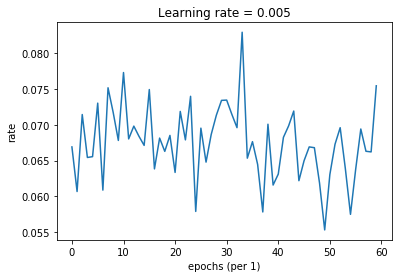

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
delta=5
def gausin_distance(x,y,delta=delta):
    H= torch.norm(x-y).cuda()
    distance = torch.exp(-H/2/(delta**2)).cuda()
    
    return distance
def gram_matrix(data,kernel=gausin_distance):
    #num=data.shape[0]
    #matrix=torch.zeros((num,num)).cuda()
    #for i in range (0,num):
    #   for j in range (0,num):
    #        matrix[i][j]=kernel(data[i],data[j])
    num=data.shape[0]
    datav3=torch.mm(data,torch.transpose(data, 0, 1).cuda()).cuda()
    datav1=torch.diag(datav3,0).cuda()
    #print(datav1.shape)
    #matrix=torch.sqrt(datav1+datav2-2*datav3)
    buf1=((-2)*datav3+datav1).cuda()
    buf2=torch.transpose(buf1, 0, 1).cuda()
    buf3=(buf2+datav1).cuda()
    #print(buf3)
    matrix = torch.exp(-buf3/2/(delta**2)).cuda()
    return matrix
def emerinal_hsic(X,Y):
    num=X.shape[0]
    #print(num)
    
    
    
    Kx=gram_matrix(X)
    
    Ky=gram_matrix(Y)
    
    H = torch.eye(num).cuda() - torch.ones((num,num), dtype = torch.float32).cuda() / num
    #print(H)
    hsic=1/(num-1)*torch.trace(torch.mm(torch.mm(torch.mm(Kx,H).cuda(),Ky).cuda(),H).cuda()).cuda()
    
    return hsic
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.datasets
from PIL import Image
batch_size=256
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        
        super(MyMNIST,self).__init__(root, train, transform, target_transform,download)
        #print(self.data)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        #print(target) 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        else:
            target=torch.as_tensor(target)
            target = F.one_hot(target,num_classes=10).cuda()

        return img, target
mnist_data=torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
#D_in, H1,H2,H3,H4,H5,H6,H7, D_out = 784, 64,32,16,8,4,2,1,10
layer_num=[784,64,32,16,8,4,2,1]
costs=[]
dtype=torch.float
continue_flag=1
PATH='./checkpoint_multilayer'
w=[]
z=[]
b=[]
if continue_flag:
    
    checkpoint = torch.load(PATH)
    
    w=checkpoint['w']
    b=checkpoint['b']

else:
    for i in range(len(layer_num)-1):
    
        w.append(torch.randn(layer_num[i],layer_num[i+1], dtype=dtype, requires_grad=True,device="cuda"))
        b.append(torch.randn(layer_num[i+1],dtype=dtype, requires_grad=True,device="cuda"))
epoches=20
lamda=100
learning_rate=0.005
data_tsne_label=[]
data_tsne_rp1=[]
data_tsne_rp2=[]
rate_list=[]
for i in range(epoches): 
    for i_batch, (img,target) in enumerate(data_loader):
        z=[]
        img=img.reshape(-1,layer_num[0]).cuda()
        
        target=torch.as_tensor(target).cuda()
        num=target.shape[0]
        #print(num)
        target=target.reshape(num,1).cuda()
        #target = F.one_hot(target,num_classes=10).cuda()
        target=torch.zeros((num,10)).cuda().scatter_(1,target,1).cuda()
        
        target=torch.as_tensor(target,dtype=dtype).cuda()
        
        z.append(torch.tanh(torch.mm(img,w[0]).cuda()+b[0].cuda()).cuda())
        for cnt in range(len(w)-1):
            
            z.append(torch.tanh(torch.mm(z[cnt],w[cnt+1]).cuda()+b[cnt+1].cuda()).cuda())
            
        grad_list=[]
        
        #for cnt in range(len(z)-1):

            
        #    cost=-emerinal_hsic(z[cnt],img)-lamda*emerinal_hsic(z[cnt],target)
        #print(cost1)
        #    cost.backward(retain_graph=True)
        #   print('!')
        #print(w1.cuda().grad)
        #    with torch.no_grad():
        #       buf=torch.zeros((w[cnt].shape)).cuda()
                #print(buf.shape)
        #       buf.copy_(w[cnt].grad)
                
        #       grad_list.append(buf)
            #print('grad1',torch.norm(grad1))
            #w2 -= learning_rate * w2.grad

            # Manually zero the gradients after updating weights
        #        w[cnt].grad.zero_()
                #print(cnt,torch.norm(buf))
            #w2.grad.zero_()
        entropy=emerinal_hsic(z[-1],img)
        information=lamda*emerinal_hsic(z[-1],target)
        cost=-entropy-information+0.0001*(entropy/information)
        rate=entropy/information
        cost.backward()
        
        with torch.no_grad():
            #w1 -= learning_rate * w1.grad
            #print('grad2',torch.norm(w2.grad))
            w[-1] -= learning_rate * w[-1].grad
            b[-1] -= learning_rate * b[-1].grad
            for cnt in range(len(w)-1):
                w[cnt] -= learning_rate * w[cnt].grad
               # print(torch.norm(w[cnt].grad))
                w[cnt].grad.zero_()
        # Manually zero the gradients after updating weights
            w[-1].grad.zero_()
            b[-1].grad.zero_()
        #    data_tsne_rp2.append(z2.cpu().data.numpy())
        #    data_tsne_rp1.append(z1.cpu().data.numpy())
        #    data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
        

        if i_batch %100 ==0:
            costs.append(cost)
            rate_list.append(rate)
            print(rate)
            print(i_batch)
            print('cost',cost)
            print('entr',entropy)
            print('inf',information)
            data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
            torch.save({
            'w': w,
            'z': z,
            'b': b,
            'data_tsne_label':target.argmax(dim=1, keepdim=True).cpu().data.numpy()
            ,'costs':costs
            #'data_tsne_rp2':data_tsne_rp2,
            #'data_tsne_rp1':data_tsne_rp1
                
            }, PATH)
            
            data_tsne_label=[]
            
            
            #data_tsne_rp1=[]
            #data_tsne_rp2=[]

            #for j,zz in enumerate(z2):
                #print(j,zz)
                #print(j,target[j])
            
plt.plot(rate_list)
plt.ylabel('rate')
plt.xlabel('epochs (per 1)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

Populating the interactive namespace from numpy and matplotlib
{'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}
!!!!
[-0.9993199]
[-0.9986223]
[-0.9991329]
[-0.9993498]
[-0.9994129]
[-0.99939144]
[-0.9994106]
[-0.99884915]
[-0.9992943]
[-0.99942386]
[-0.99910825]
[-0.9986955]
[-0.99932516]
[-0.9994245]
[-0.99940157]
[-0.99942136]
[-0.99941564]
[-0.9994148]
[-0.99941874]
[-0.9994263]
[-0.99942523]
[-0.99877566]
[-0.9989701]
[-0.99942046]
[-0.99942595]
[-0.9994262]
[-0.99879146]
[-0.99927455]
!!!!
[0.9998105]
[0.9998109]
[0.9998105]
[0.999846]
[0.9998108]
[0.999811]
[0.99981093]
[0.9998105]
[0.999846]
[0.9998383]
[0.99984574]
[-0.9993325]
[0.99981105]
[0.9998109]
[0.99981904]
[0.99981135]
[0.99981236]
[0.99983674]
[0.99981093]
[0.99943346]
[0.9998263]
[0.99983984]
[0.9995755]
[0.9993386]
[0.999811]
[0.9998124]
[-0.9994105]
[0.99981046]
[0.9998386]
[0.99975955]
[0.99984145]
[0.9995598]
[0.9998155]
[0.99974996]
[0.99981064]
[-0.89285487]
[0.999811]

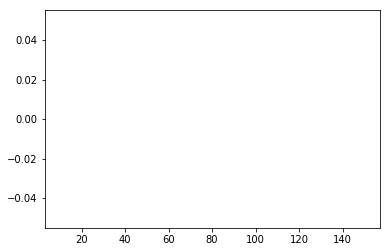

In [12]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    print(len(labels))
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
PATH='./checkpoint_multilayer'
checkpoint = torch.load(PATH)
data_tsne_label=np.array(checkpoint['data_tsne_label'])
data_tsne_rp=np.array(checkpoint['z'][-1].cpu().data.numpy())
#print(data_tsne_rp.shape)
#print(data_tsne_rp[:50,:],data_tsne_label[:50])
#for j in range(256):
#    sums=0
#    if data_tsne_label[j]==1:
#        for i in range((data_tsne_rp.shape[1])):
#            if data_tsne_rp[j][i]>=0:
#                x=1
#            else:
#                x=0
#            sums+=x*np.power(0.2,i)
#        print(sums)
#print()
pic={'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[]}
print(pic)
for i in range(10):
    print('!!!!')
    for j in range(256):
        if data_tsne_label[j]==i:
           # print(i,str(i))
           # pic[str(i)].append(data_tsne_rp[j])
           # print(data_tsne_label[j])
           print(data_tsne_rp[j])
data_tsne_label=data_tsne_label.reshape((-1))
plt.hist(data_tsne_rp[:256], bins=200, range=(10,150),histtype="stepfilled", alpha=.8)
#print(np.histogram(data_tsne_rp[:200],bins=100,range=(0,100)))
#for i in range(10):
    #plt.hist(pic[str(i)], bins=100, range=(0,100),normed=True,histtype="stepfilled", alpha=.8)
    #print('!!!')
    #print(pic[str(i)])
#print(data_tsne_label)
#data_tsne=np.array(data_tsne[:][])
#if HAS_SK:
    # Visualization of trained flatten layer (T-SNE)
 #   tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
 #   plot_only = 255
 #   low_dim_embs = tsne.fit_transform(data_tsne_rp[:plot_only,:])
 #  labels = data_tsne_label[:plot_only]
 #   plot_with_labels(low_dim_embs, labels)
plt.ioff()